<a href="https://colab.research.google.com/github/gabana04/Colaboratory/blob/main/Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=green>**Mi Proyecto Robo Trading**

##Importando libreria

In [2]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'


Python 3.10.11
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.22.4
------
Name: matplotlib
Version: 3.7.1


In [3]:
from bs4 import BeautifulSoup
import urllib.request as urllib_request
import matplotlib.pyplot as plt
import yfinance as yf
import requests
from IPython.display import clear_output
import time


##Variables

In [4]:
global importar_base_bitcoin, df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

##Extraer datos historicos del precio del Bitcoin de los ultimos 7 dias

In [5]:
import pandas as pd

def importar_base_bitcoin():
 global df_bitcoin

#Se obienen el precio del Bitcoin de los últimoa 7 días
 ticker = yf.Ticker("btc-usd")
 coin = ticker.history(start="2023-05-13", end="2023-05-19", interval="5m")

 df_bitcoin = pd.DataFrame (coin)
 return df_bitcoin

In [6]:
importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-13 00:00:00+00:00,26807.769531,26810.371094,26801.023438,26801.023438,0,0.0,0.0
2023-05-13 00:05:00+00:00,26789.650391,26808.476562,26789.650391,26808.197266,0,0.0,0.0
2023-05-13 00:10:00+00:00,26802.449219,26802.449219,26761.429688,26766.031250,6182912,0.0,0.0
2023-05-13 00:15:00+00:00,26766.490234,26773.099609,26754.144531,26754.144531,5281792,0.0,0.0
2023-05-13 00:20:00+00:00,26751.894531,26757.552734,26746.300781,26754.509766,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-18 23:35:00+00:00,26844.529297,26844.529297,26825.281250,26836.777344,0,0.0,0.0
2023-05-18 23:40:00+00:00,26838.720703,26846.666016,26838.720703,26846.666016,9080832,0.0,0.0
2023-05-18 23:45:00+00:00,26848.029297,26889.085938,26848.029297,26873.421875,5150720,0.0,0.0


##Extraer datos del valor actual del Bitcoin

In [7]:
def extraer_tendencias():
  global precio_actual, tendencia

  url = "https://coinmarketcap.com/"
  response = requests.get(url)
  soup = BeautifulSoup(response.content, "html.parser")

  btc = soup.find("div", class_="sc-cadad039-0 clgqXO").getText()
  btc = btc.replace(",", "")
  btc = btc.replace("$", "")
  precio_actual = float(btc)

  tendencia = soup.find_all("span",{"class":["sc-97d6d2ca-0 cYiHal", "sc-97d6d2ca-0 bQjSqS"]})[0]
  if "sc-97d6d2ca-0 cYiHa1" in " ".join(tendencia["class"]):
      tendencia = "Alta"
  else:
      tendencia = "Baja"
  
  return [precio_actual, tendencia]


In [8]:
extraer_tendencias()

[27697.51, 'Baja']

## Limpieza de datos

Trabajando en una copia

In [9]:
from pandas.errors import ClosedFileError
def limpieza_datos():
  global df_bitcoin, df_bitcoin_limpio, media_bitcoin

#Iniciamos nuestra limpieza de datos en la copia de nuestro DataFrame.
  df_bitcoin_limpio=df_bitcoin.copy()
  df_bitcoin_limpio

#Para eliminar datos duplicados en nuestra columna "indice" se aplica el siguiente 
#método para manejar índices unicos.
  unicos= df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio= df_bitcoin_limpio.reindex(unicos)


#En nuestra columna "Close" buscanmos valores nulos y los eliminamos.
  df_bitcoin_limpio.dropna(subset=["Close"], inplace=True)


#Identificar todos los datos menores a 0 en la columna "Volume" y eliminarlos
  seleccion = (df_bitcoin_limpio['Volume'] > 0)
  df_bitcoin_limpio= df_bitcoin_limpio[seleccion]

#Calculo del precio promedio del Bitcoin
  media_bitcoin = df_bitcoin_limpio['Close'].mean()
  df_bitcoin_limpio['Close'].replace(0,media_bitcoin)

#Se crea el objeto valor que contiene los precios de muestra columna "Close"
  close = df_bitcoin_limpio["Close"]

#Ahora se trabaja en la creación de nuestros quartiles.
#Se identifican y se eliminan los outliers en el precio del Bitcon del boxplot
  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ

#Se crea el criterio de seleccion para nuestro boxplot 
#Finalmente tomamos nuestro valores limpios y los regresamos a nuestro DataFrame
  seleccion =((close >= Q1) & (close <= Q3))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  return (df_bitcoin_limpio, media_bitcoin)




In [10]:
limpieza_datos()

(                                   Open          High           Low  \
 Datetime                                                              
 2023-05-13 01:15:00+00:00  26873.750000  26943.167969  26872.304688   
 2023-05-13 01:20:00+00:00  26955.857422  26984.714844  26943.917969   
 2023-05-13 01:25:00+00:00  26988.273438  26989.074219  26941.009766   
 2023-05-13 01:30:00+00:00  26935.880859  26944.351562  26902.968750   
 2023-05-13 18:50:00+00:00  27030.482422  27030.482422  26959.718750   
 ...                                 ...           ...           ...   
 2023-05-18 21:45:00+00:00  26998.724609  26998.724609  26970.935547   
 2023-05-18 21:50:00+00:00  26950.947266  26981.611328  26929.906250   
 2023-05-18 21:55:00+00:00  26930.185547  26942.365234  26926.388672   
 2023-05-18 22:05:00+00:00  26874.310547  26933.841797  26874.310547   
 2023-05-18 22:10:00+00:00  26931.375000  26938.408203  26923.265625   
 
                                   Close     Volume  Dividends

In [11]:
media_bitcoin = df_bitcoin_limpio['Close'].mean()
media_bitcoin

27108.824035357982

<Axes: >

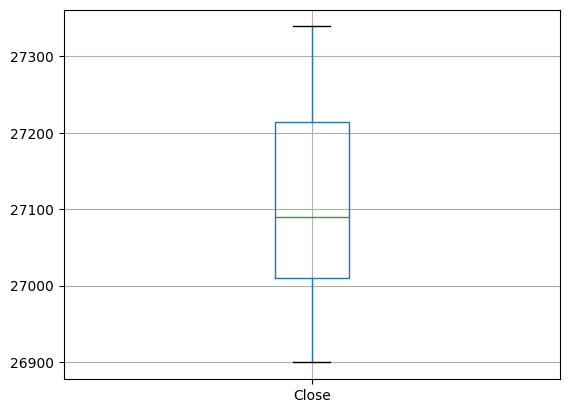

In [12]:
#Representación de nuestros outliers en el boxplot
df_bitcoin_limpio.boxplot(["Close"])

array([[<Axes: title={'center': 'Close'}>]], dtype=object)

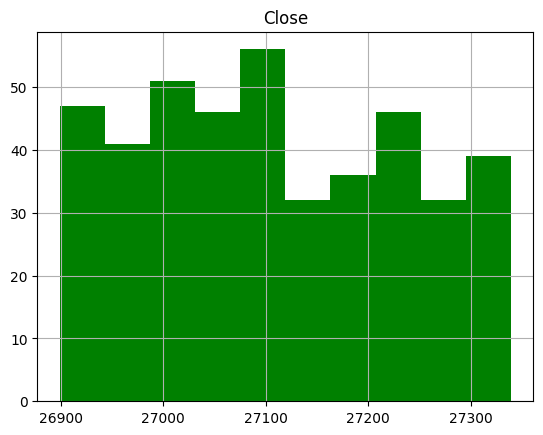

In [13]:
#Histograma representa los precios del Bitcoin en nuestra columna y la frecuencia
#con la que aparecen en nuestro Banco de datos
df_bitcoin_limpio.hist(["Close"], color = "green")

##Toma de decisiones

In [14]:
def tomar_decisiones():
  global algoritmo_decision, df_bitcoin_limpio, media_bitcoin, precio_actual

#Valor de la media
  media_bitcoin = df_bitcoin_limpio['Close'].mean()

#Criterios para la toma de decisión
  if (precio_actual >= media_bitcoin and tendencia == "Baja"):
      algoritmo_decision = "Vender "
  elif (precio_actual < media_bitcoin and tendencia == "Alta"):
      algoritmo_decision ="Comprar"
  return algoritmo_decision

In [15]:
tomar_decisiones()

'Vender '

##Visualización

In [16]:
import matplotlib.pyplot as plt

In [17]:
def visualizacion():
  global df_bitcoin_limpio, media_bitcoin, precio_actual, algoritmo_decision, df_bitcoin

  #Adicionar la columna Promedio al DataFrame original y almacenar nuestra variable
  #media_bitcoin
  df_bitcoin["Promedio"]= media_bitcoin
   
   #Establecer el area de nuestro grafico
  plt.figure(figsize=(16,5))  

  #Titulo de nuestra gráfica
  plt.title("Precio del Bitcoin al cierre de la jornada")

  #Dibujar una linea en nuestro grafico con los datos de las columnas indice y Close de nuestro Data Frame original 
  plt.plot(df_bitcoin.index, df_bitcoin["Close"])
  plt.plot(df_bitcoin.index, df_bitcoin["Promedio"])
  algoritmo_decision = tomar_decisiones()

  #Se muestra un mensaje dentro del grafico con la decisión calculada con el algoritmo de decisión.
  plt.annotate(algoritmo_decision, xy = (df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), fontsize = 14)
  plt.show()


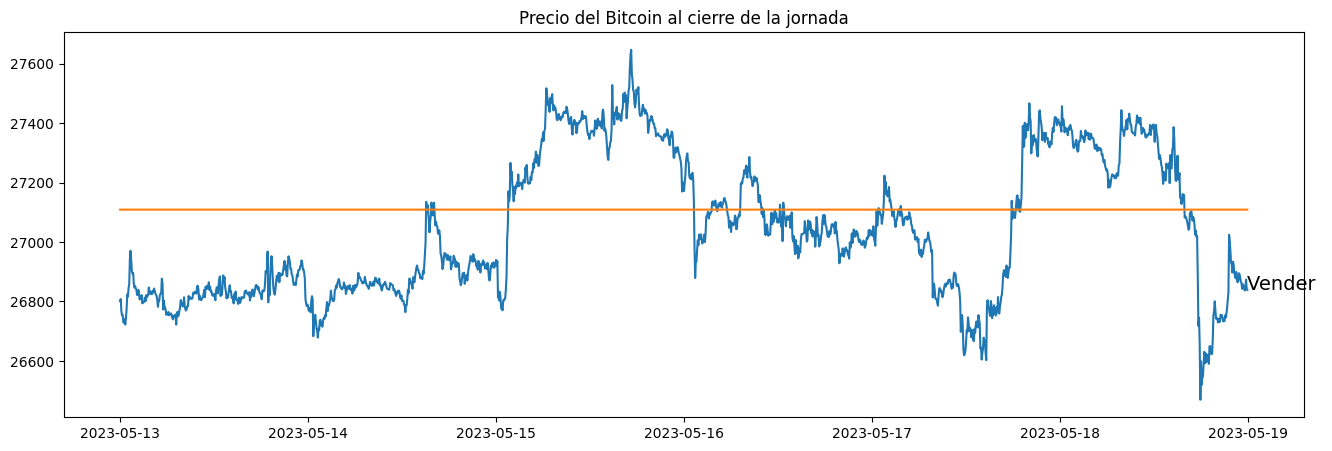

In [18]:
visualizacion()

##Automatización

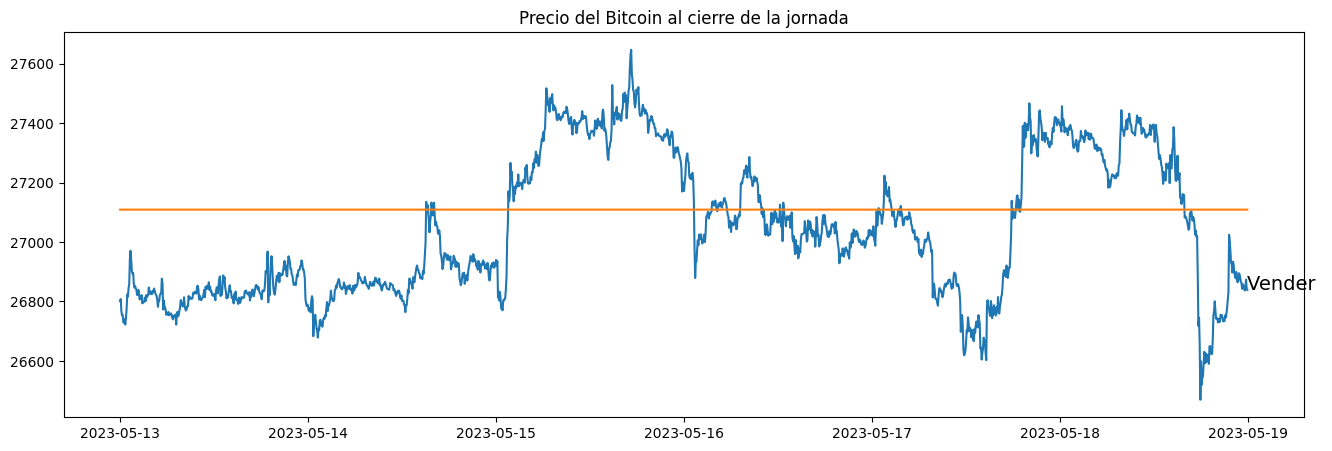

In [ ]:
from IPython.display import clear_output

while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)
